In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import shuffle
import utils
import shutil
import pickle
import custom_model
import glob
import pandas as pd
import numpy as np
import glob
import itertools, os
from tqdm import tqdm
from scipy.stats import pearsonr

2024-01-24 04:12:47.758267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
res = utils.read_pickle('../results/gencode_tss_predictions/borzoi/RAB3GAP1_chr2_135052307_+.pickle')

In [27]:
model_name = 'borzoi'
target_df = pd.read_csv(f'../data/{model_name}_targets_human.txt', sep='\t')
cell_lines = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']

cell_line_info = utils.get_borzoi_targets(target_df, cell_lines)
cell_line_info

{'K562 ENCODE, biol_': {'output': [4, 5], 'target': '872&873'},
 'GM12878 ENCODE, biol_': {'output': [2, 3], 'target': '870&871'},
 'PC-3': {'output': [0, 1], 'target': '298&299'}}

In [29]:
(res[0, :, :, :].mean(axis=0).sum(axis=0)/2)[cell_line_info['PC-3']['output']]

array([32.4   ,  0.2417], dtype=float16)

In [30]:
pd.read_csv('../results/summary_csvs/borzoi/298&299_PC-3_selected_genes.csv')

,Unnamed: 0,Chromosome,Start,gene_name,gene_id,Strand,PC-3
0,53071,chrX,54044473,PHF8,ENSG00000172943.21,-,8.960938
1,22343,chr8,97869063,MATN2,ENSG00000132561.14,+,8.968750
2,9763,chr3,122325247,CSTA,ENSG00000121552.4,+,8.968750
3,17180,chr6,43182184,CUL9,ENSG00000112659.14,+,8.968750
4,45552,chr19,23914875,ZNF726,ENSG00000213967.12,+,8.976562
...,...,...,...,...,...,...,...
9995,9601,chr3,100709549,TFG,ENSG00000114354.15,+,52.812500
9996,33331,chr12,56688284,PTGES3,ENSG00000110958.16,-,55.843750
9997,49125,chr20,58891420,GNAS,ENSG00000087460.29,+,56.906250
9998,19398,chr7,30594842,GARS1,ENSG00000106105.15,+,58.187500


In [12]:
pd.read_csv('../results/summary_csvs/borzoi/298&299_PC-3_selected_genes.csv')

,Unnamed: 0,Chromosome,Start,gene_name,gene_id,Strand,PC-3
0,6110,chr2,135052307,RAB3GAP1,ENSG00000115839.19,+,0.627930
1,8402,chr2,208254322,IDH1,ENSG00000138413.14,-,0.627930
2,36759,chr15,38252835,SPRED1,ENSG00000166068.13,+,0.627930
3,2735,chr1,236686638,ACTN2,ENSG00000077522.15,+,0.628418
4,11277,chr3,121545988,POLQ,ENSG00000051341.15,-,0.628418
...,...,...,...,...,...,...,...
9995,34025,chr13,27621983,POLR1D,ENSG00000186184.20,+,41.093750
9996,15992,chr5,131165334,HINT1,ENSG00000169567.13,-,41.125000
9997,28372,chr11,61430055,ENSG00000256591,ENSG00000256591.5,+,41.937500
9998,11492,chr3,139389736,COPB2,ENSG00000184432.11,-,42.031250


In [54]:
wt_res = pd.read_csv('../results/context_dependence_test/enformer_result_summary.csv')

In [56]:
wt_res['seq_id'] = [p.split('/')[-1] for p in wt_res['path']]

6573    97.94487
Name: wt, dtype: float64

In [72]:
one_seq_path.split('_')[0]

'../results/subsample/PC-3'

In [84]:
wt.iloc[0]

97.94487

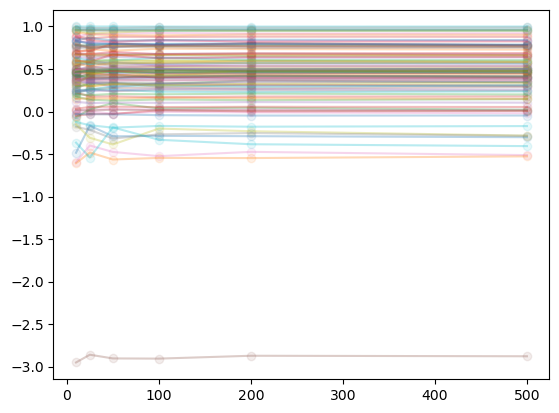

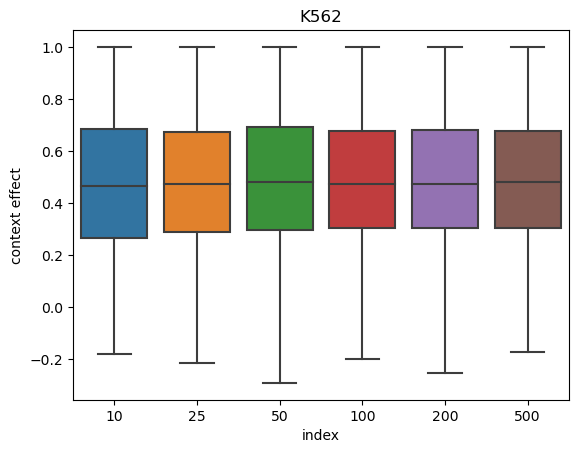

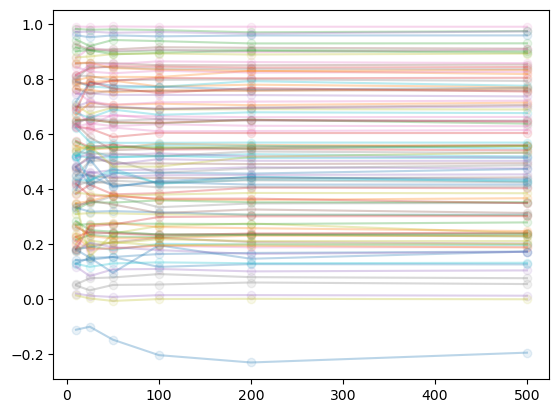

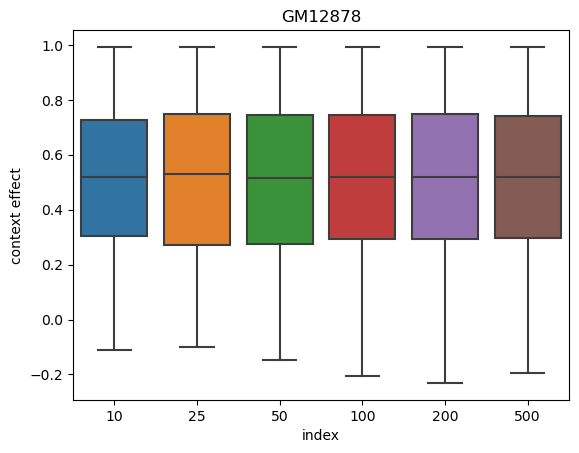

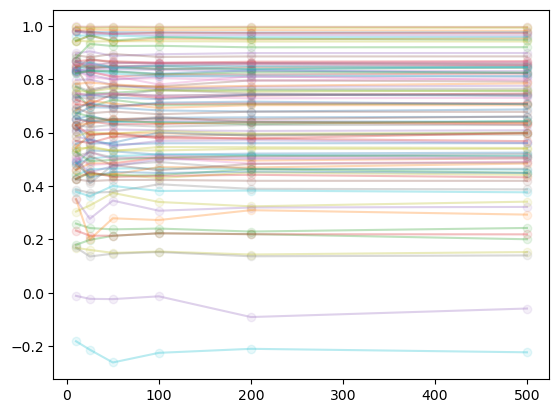

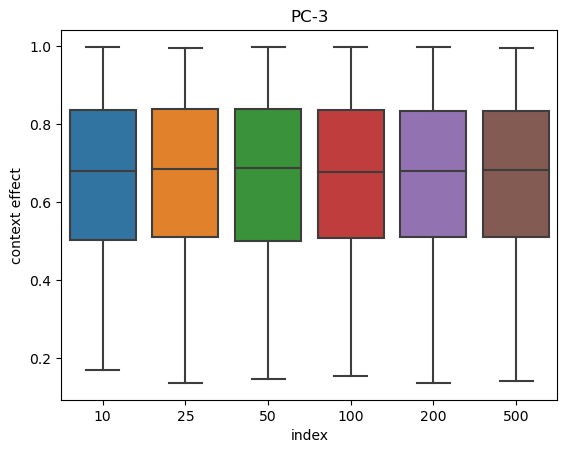

In [98]:
label = 'context effect'
for c in ['K562', 'GM12878', 'PC-3']:
    cell_line_dfs = []
    for one_seq_path in glob.glob(f'../results/subsample/{c}*'):
        one_seq = utils.read_pickle(one_seq_path)
        wt = wt_res[(wt_res['seq_id']=='_'.join(one_seq_path.split('/')[-1].split('_')[1:])) & (wt_res['cell line']==one_seq_path.split('/')[-1].split('_')[0])]['wt'].iloc[0]
        
        df = pd.DataFrame.from_dict({k:[(wt - v.mean()) / wt] for k,v in one_seq.items()}).T
        df.columns = [label]
        df = df.reset_index()
        # df['shuffled preds'] = df['shuffled preds'] #/ df['shuffled preds'].iloc[-1]
        plt.scatter(df['index'], df[label], alpha=0.1)
        plt.plot(df['index'], df[label], alpha=0.3)
        cell_line_dfs.append(df)
    plt.show()
    cell_line_dfs = pd.concat(cell_line_dfs)
    sns.boxplot(data=cell_line_dfs, x='index', y=label, showfliers=False)
    plt.title(c)
    plt.show()


In [168]:
ax

<Axes: >

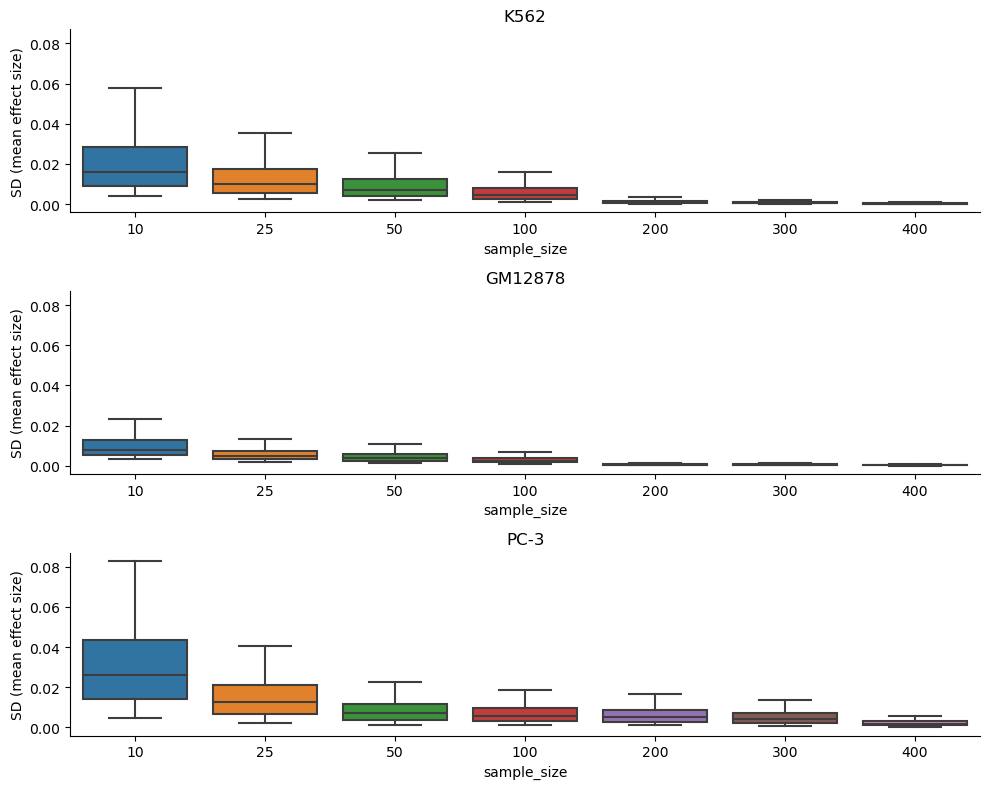

In [180]:
X = one_seq[500].copy()
fig, axes = plt.subplots(3, 1, figsize=[10, 8], sharey=True)
for j, c in enumerate(['K562', 'GM12878', 'PC-3']):
    ax = axes[j]
    SE_of_means = {k:[] for k in [10, 25, 50, 100, 200, 300, 400]}
    np.random.shuffle(X)
    for one_seq_path in glob.glob(f'../results/subsample/{c}*'):
        one_seq = utils.read_pickle(one_seq_path)
        wt = wt_res[(wt_res['seq_id']=='_'.join(one_seq_path.split('/')[-1].split('_')[1:])) & (wt_res['cell line']==one_seq_path.split('/')[-1].split('_')[0])]['wt'].iloc[0]
        
    
        for sample_size in SE_of_means.keys():
            normalized_sample_means = []
            for i in range(0, 500, sample_size):
                one_mean = X[i:i+sample_size].mean()
                normalized_sample_means.append((wt - one_mean) / wt)
            SE_of_means[sample_size].append(np.std(normalized_sample_means))
    df = pd.DataFrame.from_dict(SE_of_means)
    df = df.melt(var_name='sample_size', value_name='SD (mean effect size)')
    
    sns.boxplot(data=df, x='sample_size', y='SD (mean effect size)', showfliers=False, ax=ax)

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(c)
plt.tight_layout()

In [182]:
df.iloc[:df.shape[0]//2]

,sample_size,SD (mean effect size)
0,10,0.027960
1,10,0.055732
2,10,0.016548
3,10,0.061707
4,10,0.016515
...,...,...
345,100,0.002532
346,100,0.001826
347,100,0.001040
348,100,0.002441


In [185]:
tss_df = pd.concat(pd.read_csv(f, index_col='Unnamed: 0') for f in glob.glob(f'../results/gencode_tss_predictions/enformer/*selected_tss.csv'))
tss_df = tss_df.iloc[:, :-3].drop_duplicates()

In [186]:
tss_df.iloc[:tss_df.shape[0]//2]

,Chromosome,Start,gene_name,gene_id,Strand
18420,chr6,43576038,XPO5,ENSG00000124571.18,-
29211,chr11,118956297,UPK2,ENSG00000110375.3,+
28811,chr11,73647625,PLEKHB1,ENSG00000021300.14,+
48428,chr19,58002819,ZNF606,ENSG00000166704.13,-
34582,chr13,45418373,SLC25A30,ENSG00000174032.17,-
...,...,...,...,...,...
49976,chr21,41168159,BACE2,ENSG00000182240.16,+
34269,chr13,95677138,DNAJC3,ENSG00000102580.15,+
25403,chr9,128947603,DOLK,ENSG00000175283.8,-
25703,chr10,17644150,STAM,ENSG00000136738.15,+


In [187]:
tss_df.iloc[tss_df.shape[0]//2:]

,Chromosome,Start,gene_name,gene_id,Strand
20623,chr7,21945884,CDCA7L,ENSG00000164649.20,-
29503,chr11,2929420,PHLDA2,ENSG00000181649.8,-
47100,chr19,10403542,CDC37,ENSG00000105401.9,-
36762,chr15,39581078,THBS1,ENSG00000137801.11,+
38246,chr15,89893981,AP3S2,ENSG00000157823.17,-
...,...,...,...,...,...
41750,chr17,59619909,CLTC,ENSG00000141367.13,+
29761,chr11,17077667,RPS13,ENSG00000110700.7,-
23366,chr8,108248718,EIF3E,ENSG00000104408.11,-
564,chr1,28236153,ATP5IF1,ENSG00000130770.18,+
